## Where everything comes from

Data were collected on April 22, 2020. The source files can be found on the Google Drive:

   * Our raw data: **penn-2020-04-22/PrincetonFlowMeter_simtest.out**
   * NM3 data: **penn-2020-04-22/200422_princetonmonitor.txt**
   * ASL data: **ASL Files/***

Our timeseries data, **penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv**, were derived using

```bash
./device_json_to_timeseries.py penn-2020-04-22/PrincetonFlowMeter_simtest.out --start-time-at-zero > penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv
```

Our breaths data, **penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv**, were derived using

```bash
./timeseries_to_breaths.py penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv > penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv
```

In [1]:
import re
import string
import numpy as np

import json
import matplotlib.pyplot as plt
import scipy.signal
import scipy.integrate

import pandas as pd

## Reading in our data

In [2]:
our_timeseries = pd.read_csv("../penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv")
our_timeseries.columns = our_timeseries.columns.str.strip()
our_timeseries

,time (sec),pressure (cm H2O),flow (L/min),volume (mL)
0,0.000,-0.2040,-0.7198,368.0971
1,0.020,-0.1749,1.3485,368.2012
2,0.040,-0.1615,1.0696,368.6004
3,0.060,-0.1962,0.0000,368.7713
4,0.080,-0.1898,1.3485,368.9862
...,...,...,...,...
140440,2813.227,-0.0410,1.5894,392.3519
140441,2813.247,-0.0371,1.0696,392.4895
140442,2813.267,-0.0615,0.0000,392.3620
140443,2813.287,-0.0142,1.5894,392.3222


In [3]:
our_breaths = pd.read_csv("../penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv")
our_breaths.columns = our_breaths.columns.str.strip()
our_breaths

,inhale timestamp (sec),inhale flow (L/min),inhale dV/dt (mL/sec),inhale dP/dt (cm H2O/sec),inhale compliance (ml/cm H2O),min pressure (cm H2O),full timestamp (sec),full pressure (cm H2O),full volume (mL),expiratory tidal volume (mL),...,exhale dP/dT (cm H2O/sec),exhale compliance (ml/cm H2O),max pressure (cm H2O),empty timestamp (sec),empty pressure (cm H2O),empty volume (mL),exhale time (sec),average flow (L/min),average pressure (cm H2O),time since last (sec)
0,40.764000,38.2733,163.159314,2.580221,63.234627,nan,41.044000,0.5228,473.2305,nan,...,-0.878237,147.122343,7.8072,43.064499999999995,-0.4899,354.1009,nan,nan,nan,nan
1,44.825000,38.1687,316.186431,4.670678,67.696052,-1.112,45.185000,-1.3128,508.5437,154.44279999999998,...,-0.342405,392.116560,8.4128,47.13602222222223,-0.1962,360.1115,nan,0.9061990196078437,0.1967941176470588,nan
2,48.847044,40.7215,337.888723,3.662988,92.244006,-0.534,49.187067,-0.7789,523.3885,163.27700000000004,...,-1.212890,121.931272,9.2216,51.108999999999995,0.0976,342.6396,nan,0.6203217171717174,0.5621944444444444,nan
3,52.869078,43.1976,389.210240,1.829615,212.727945,-0.2836,53.229844,-0.4096,544.3130,201.67340000000002,...,-1.651000,102.582467,10.3067,55.11430000000001,0.4189,336.4437,nan,0.8131910447761196,0.9300835820895522,nan
4,56.876000,43.4641,432.391585,5.874595,73.603647,-0.0544,57.256000,0.1094,562.9837,226.54000000000002,...,-1.587964,119.286326,11.2895,60.31600000000002,-0.0371,307.7576,nan,-0.1850434615384612,0.988816923076923,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,2606.874644,38.5857,606.547984,7.615027,79.651455,8.3971,2607.556322,20.2773,694.9151,469.32110000000006,...,-7.918338,53.344067,20.3222,2610.2032333333336,10.191,231.946,nan,0.11289086294416255,13.198745177664973,nan
640,2610.905267,48.8901,764.719931,10.622699,71.989229,8.3915,2611.666000,25.5559,796.8703,564.9243,...,-10.160144,52.681924,25.7000,2614.286,10.0721,184.9754,nan,0.1939682926829258,15.148255609756097,nan
641,2614.926000,38.7308,592.852525,7.196724,82.378112,8.3151,2615.546000,20.3182,655.6604,470.68499999999995,...,-7.707564,56.636711,20.3607,2618.227,10.2185,220.6248,nan,-0.6064193877551021,13.174528571428572,nan
642,2618.887000,42.0025,612.028976,7.461725,82.022456,8.3285,2619.567011,20.2702,691.6708,471.046,...,-8.353320,50.968671,20.3261,2622.2070222222223,10.1595,231.1344,nan,0.029952500000000555,13.149691,nan


## Reading in the NM3 data

In [4]:
def read_nm3(filename):
    with open(filename) as file:
        for i, line in enumerate(file):
            if i == 8:
                break

        time, pressure, flow = [], [], []
        for line in file:
            row = line.strip().split()
            time.append(float(row[0]))
            pressure.append(float(row[2]))
            flow.append(float(row[3]))

        return {"time (sec)": np.array(time), "pressure (cm H20)": np.array(pressure), "flow (L/min)": np.array(flow)}

In [5]:
nm3_timeseries = pd.DataFrame(read_nm3("../penn-2020-04-22/200422_princetonmonitor.txt"))
nm3_timeseries

,time (sec),pressure (cm H20),flow (L/min)
0,39078.5764,-1.165036,-2.176782
1,39078.5774,-1.165036,-2.073890
2,39078.5784,-1.165036,-2.365417
3,39078.5794,-1.165036,-2.108187
4,39078.5804,-1.165036,-1.816660
...,...,...,...
2720995,41799.5714,-0.142530,-1.885255
2720996,41799.5724,-0.142530,-2.125336
2720997,41799.5734,-0.142530,-2.622647
2720998,41799.5744,-0.142530,-2.176782


## Reading in the ASL data

In [6]:
def asl2numpy(filename, numcolumns=None):
    with open(filename, "rb") as file:
        headerbytes = None
        for line in file:
            if re.search(rb"column", line, re.I):
                break
            m = re.search(rb"([0-9]+) byte header", line)
            if m is not None:
                headerbytes = int(m.group(1))

        columns = []
        for line in file:
            column = line.strip()
            if len(column) != 0 and all(x in string.printable.encode() for x in column):
                columns.append(column)
            elif len(columns) != 0:
                break

        if numcolumns is not None:
            columns = columns[:numcolumns]
            columns = columns + [b"unknown %d" % i for i in range(numcolumns - len(columns))]

        file.seek(0)
        return np.frombuffer(file.read()[headerbytes:], dtype=">f4").astype("<f4").view([(x.decode(), "<f4") for x in columns])

In [7]:
asl_timeseries = pd.DataFrame(asl2numpy("../ASL Files/Princeton2020_1.rwb"))
asl_timeseries

,Time (sec),Airway Pressure (cmH2O),Muscle Pressure (cmH2O),Tracheal Pressure (cmH2O),Chamber 1 Volume (L),Chamber 2 Volume (L),Total Volume (L),Chamber 1 Pressure (cmH2O),Chamber 2 Pressure (cmH2O),Breath File Number (#),Aux 1 (V),Aux 2 (V),Oxygen Sensor (V)
0,194.455078,6.324864,0.000763,7.378500,0.184478,0.184478,0.369077,7.378500,7.378500,48.0,4.951477,4.942627,2.545013
1,194.457031,6.331731,0.000763,7.373922,0.184356,0.184356,0.368817,7.373922,7.373922,48.0,4.951477,4.942627,2.545013
2,194.458984,6.338598,0.000763,7.369345,0.184234,0.184234,0.368568,7.369345,7.369345,48.0,4.951477,4.942627,2.545013
3,194.460938,6.345464,0.000763,7.364767,0.184111,0.184111,0.368320,7.364767,7.364767,48.0,4.951477,4.942627,2.545013
4,194.462891,6.334020,0.000763,7.360189,0.183990,0.183990,0.368084,7.360189,7.360189,48.0,4.969482,4.951477,2.545319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867555,3842.023438,0.659953,0.000763,0.647745,0.012982,0.012982,0.025971,0.647745,0.647745,942.0,4.904327,4.887695,2.366943
1867556,3842.025391,0.656138,0.000763,0.647745,0.012982,0.012982,0.025971,0.647745,0.647745,942.0,4.911957,4.891663,2.365417
1867557,3842.027344,0.652323,0.000763,0.647745,0.012982,0.012982,0.025958,0.647745,0.647745,942.0,4.911957,4.891663,2.365417
1867558,3842.029297,0.648508,0.000763,0.647745,0.012982,0.012982,0.025958,0.647745,0.647745,942.0,4.911957,4.891663,2.365417


In [8]:
asl_breaths = pd.DataFrame(asl2numpy("../ASL Files/Princeton2020_1.brb"))
asl_breaths

,Breath Num.,Breath Type,I Time (s),Insp (%),E Time (s),Pause Time (s),Pause (%),Insp Vt (mL),Exp Vt (mL),Ppeak (cmH2O),...,Pressure Filter,Insp Circuit Resistance Setting,Exp Circuit Resistance Setting,Circuit Compliance Setting,Insp Detection Vol Threshold (mL),Exp Detection Vol Threshold (mL),Effort Detection Threshold (cmH2O),Conditions Setting,Peak Exp. Flow (mL/S),P_0.1 (cmH2O)
0,0.0,1.0,1.255859,48.164795,1.351562,0.0,0.0,150.828735,90.231339,0.406653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,-0.130257
1,1.0,0.0,-1.347656,-3631.578857,1.384766,0.0,0.0,90.208977,90.402573,0.192819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.005084
2,2.0,0.0,-1.347656,-3631.578857,1.384766,0.0,0.0,90.210442,90.404045,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.005084
3,3.0,0.0,-1.384766,-723.469360,1.576172,0.0,0.0,90.404045,92.092293,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,0.998148
4,4.0,0.0,-1.576172,-26900.000000,1.582031,0.0,0.0,92.092293,92.108589,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.111620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57031,57031.0,0.0,0.003906,33.333332,0.007812,0.0,0.0,0.012911,0.014620,0.649549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.350137,0.000000
57032,57032.0,0.0,0.003906,40.000000,0.005859,0.0,0.0,0.009785,0.004445,0.646289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.368326,0.000000
57033,57033.0,0.0,0.011719,300.000000,-0.007812,0.0,0.0,0.004787,0.003419,0.642960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000
57034,57034.0,0.0,0.019531,83.333336,0.003906,0.0,0.0,0.006008,0.000537,0.646705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.156880,0.000000


### Derive flow from volume for ASL

Chamber 1 volume and chamber 2 volume are not that different (and I don't know what difference they signify), so I take total volume.

In [9]:
asl_timeseries["flow (L/min)"] = np.gradient(asl_timeseries["Total Volume (L)"], asl_timeseries["Time (sec)"] / 60)

## Overlaying flow to match times

The three plots are early, mid, and late in the session, zoomed in to see breaths.

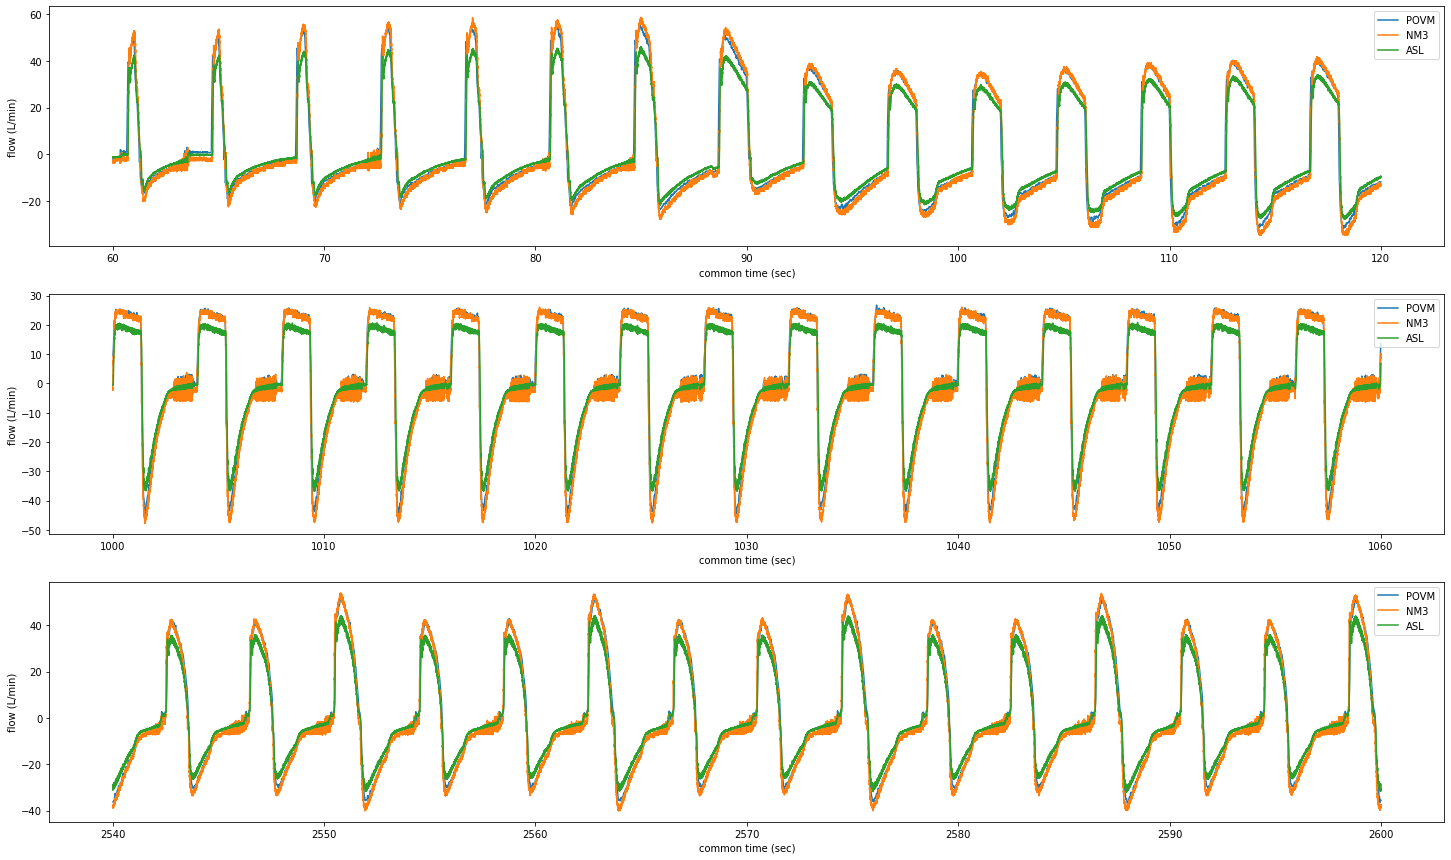

In [10]:
nm3_timeseries["time_shifted"] = nm3_timeseries["time (sec)"] - 39049.6    # tweaked by hand
asl_timeseries["time_shifted"] = asl_timeseries["Time (sec)"] - 1061.8     # tweaked by hand

def plot_in_window(ax, low, high):
    our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "flow (L/min)", ax=ax)
    nm3_timeseries[(low < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax)
    asl_timeseries[(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax)
    ax.legend(["POVM", "NM3", "ASL"], loc="upper right")
    ax.set_ylabel("flow (L/min)")
    ax.set_xlabel("common time (sec)")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
plot_in_window(ax1, 60, 120)
plot_in_window(ax2, 1000, 1060)
plot_in_window(ax3, 2540, 2600)

## Pressure comparisons

These require slight tweaks to the time offset—the flow-measuring and pressure-measuring devices are probably offset in the stream and therefore see features at different times (by a tenth of a second or so).

Of all of ASL's "pressure" measurements, "airway pressure" is the only one that's remotely shaped like what we're measuring (both POVM and NM3).

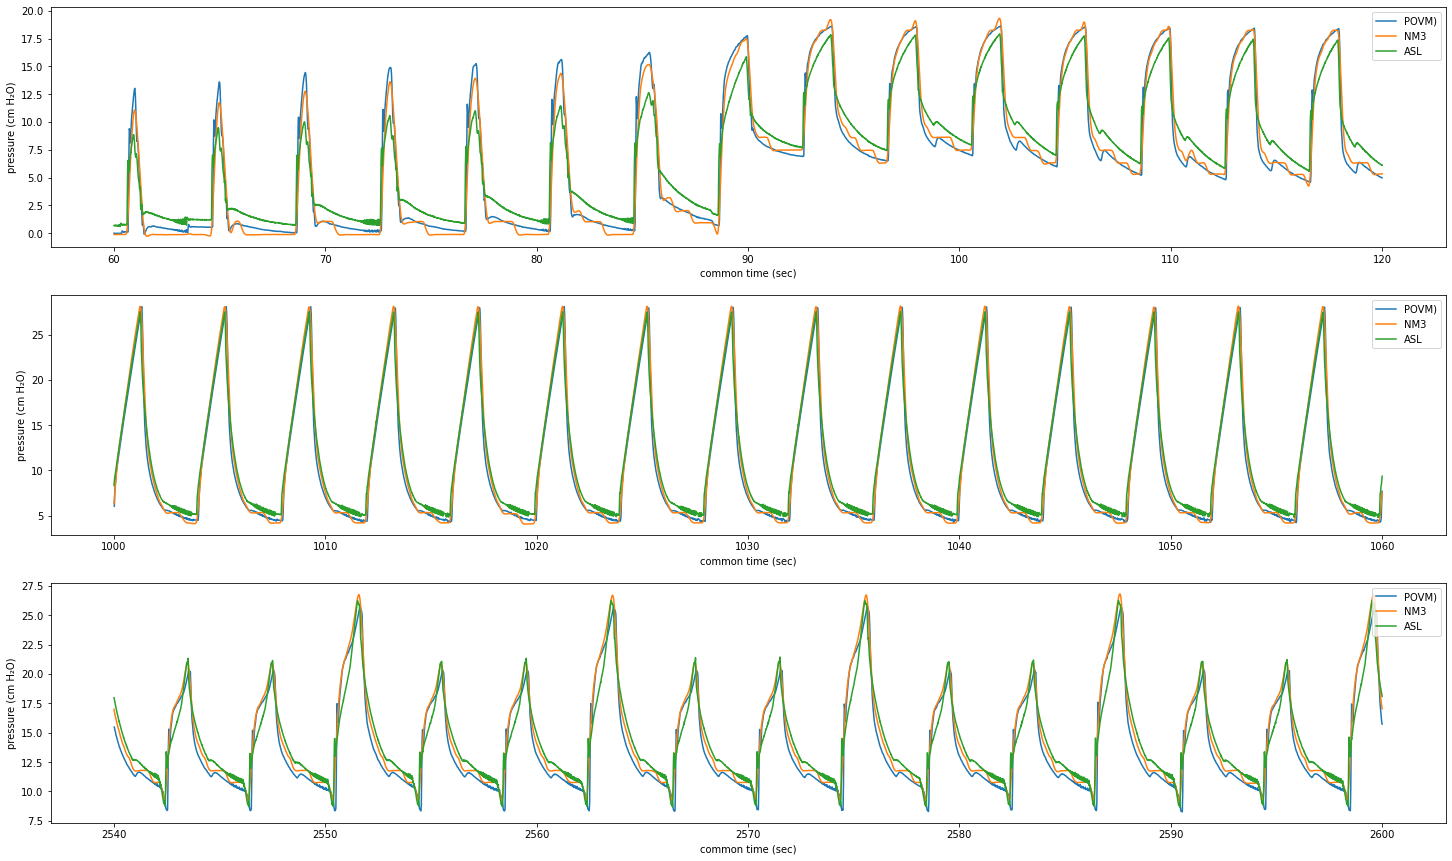

In [11]:
nm3_timeseries["time_shifted_pressure"] = nm3_timeseries["time_shifted"] - 0.2   # tweaked by hand
asl_timeseries["time_shifted_pressure"] = asl_timeseries["time_shifted"] - 0.1   # tweaked by hand

def plot_in_window(ax, low, high):
    our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "pressure (cm H2O)", ax=ax)
    nm3_timeseries[(low < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax)
    asl_timeseries[(low < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax)
    ax.legend(["POVM)", "NM3", "ASL"], loc="upper right")
    ax.set_ylabel("pressure (cm H₂O)")
    ax.set_xlabel("common time (sec)")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
plot_in_window(ax1, 60, 120)
plot_in_window(ax2, 1000, 1060)
plot_in_window(ax3, 2540, 2600)

## Reproducing the flow plot in the paper (to replace it)

I have to find that time range again, and now the common time has a different offset.

This plot should replace the one in the paper because this one is derived from timeseries that were produced by the main codebase, not a random notebook. If we run `device_json_to_timeseries.py` again and re-evaluate this notebook, we can keep the following plot up to date.

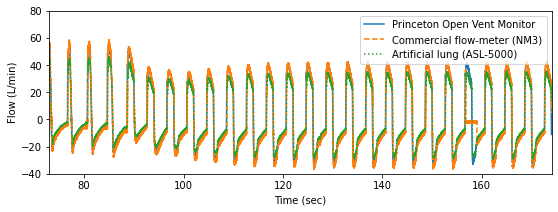

In [12]:
low, high = 73, 174

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "flow (L/min)", ax=ax, linewidth=1.5)
nm3_timeseries[(low < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax, linewidth=1.5, linestyle="--")
asl_timeseries[(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax, linewidth=1.5, linestyle=":")
ax.legend(["Princeton Open Vent Monitor", "Commercial flow-meter (NM3)", "Artificial lung (ASL-5000)"], loc="upper right")
ax.set_ylabel("Flow (L/min)")
ax.set_xlabel("Time (sec)")
ax.set_xlim(low, high)
ax.set_ylim(-40, 80)
fig.savefig("../povm-nm3-asl.pdf")

## Matching time-window for pressure

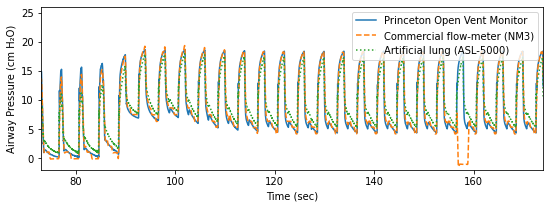

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "pressure (cm H2O)", ax=ax, linewidth=1.5)
nm3_timeseries[(low < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax, linewidth=1.5, linestyle="--")
asl_timeseries[(low < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax, linewidth=1.5, linestyle=":")
ax.legend(["Princeton Open Vent Monitor", "Commercial flow-meter (NM3)", "Artificial lung (ASL-5000)"], loc="upper right")
ax.set_ylabel("Airway Pressure (cm H₂O)")
ax.set_xlabel("Time (sec)")
ax.set_xlim(low, high)
ax.set_ylim(-2, 26)
fig.savefig("../povm-nm3-asl-pressure.pdf")

## Breath records in the time window 110‒174 sec

That's a stable region that can be averaged over. The NM3 glitch is not relevant because NM3 doesn't have derived quantities.

The ASL timeseries has a "Breath File Number (#)", which sounds and awful lot like what we want.

In [14]:
np.unique(asl_timeseries[(110 < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < 174)]["Breath File Number (#)"]).astype(int)

array([275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287,
       288, 289, 290])

There's 16 of them, which is also a good sign. (Count in the plot, starting at 110 seconds: we'd expect anything from 15 to 17.)

In [15]:
pd.options.display.max_rows = 150
asl_breaths_relevant = asl_breaths[(275 <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= 290)]
asl_breaths_relevant.T

,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290
Breath Num.,2.750000e+02,276.000000,277.000000,278.000000,2.790000e+02,280.000000,281.000000,2.820000e+02,2.830000e+02,2.840000e+02,2.850000e+02,286.000000,2.870000e+02,2.880000e+02,2.890000e+02,290.000000
Breath Type,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
I Time (s),3.906250e-03,0.001953,-0.021484,0.003906,1.953125e-03,0.001953,-0.005859,3.906250e-03,3.906250e-03,1.953125e-03,1.953125e-03,0.003906,-7.812500e-03,3.906250e-03,3.906250e-03,0.005859
Insp (%),5.000000e+01,8.333333,-275.000000,66.666664,3.333333e+01,16.666666,-20.000000,5.000000e+01,5.000000e+01,2.500000e+01,3.333333e+01,25.000000,-1.333333e+02,5.000000e+01,5.000000e+01,75.000000
E Time (s),3.906250e-03,0.021484,0.029297,0.001953,3.906250e-03,0.009766,0.035156,3.906250e-03,3.906250e-03,5.859375e-03,3.906250e-03,0.011719,1.367188e-02,3.906250e-03,3.906250e-03,0.001953
Pause Time (s),0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
Pause (%),0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
Insp Vt (mL),2.577699e-04,0.000619,0.044304,0.002990,1.444638e-02,0.000052,0.013666,9.278142e-04,2.474142e-03,2.628739e-03,1.268623e-02,0.000052,2.738246e-02,1.026377e-02,1.072759e-02,0.002628
Exp Vt (mL),1.113958e-02,0.044304,0.065449,0.010632,1.001318e-02,0.015418,0.067961,1.073473e-02,8.407899e-03,1.944491e-02,2.543143e-02,0.027434,4.135711e-02,2.702140e-02,2.610102e-02,0.010779
Ppeak (cmH2O),1.308531e+00,1.311097,1.311097,1.310681,1.315813e+00,1.319142,1.316784,1.293480e+00,1.299098e+00,1.308045e+00,1.315675e+00,1.314981,1.314912e+00,1.309432e+00,1.303606e+00,1.303190


However, none of these quantities are as expected.

   * The peak, mean, and PEEP pressures are all very nearly equal to one another (1.3 cm H₂O), which suggests that the pressure is not going through any cycles. We don't know whether it's airway pressure, chamber pressure, or something else, but at the very least we'd expect it to _vary_ on the scale of 5‒20 cm H₂O. If we zoom out to all breaths, these quantities do vary on that scale.
   * The volume 1 peak and volume 2 peak are very likely chamber 1 and chamber 2, but for these breaths, the volume is always zero. That's not right: the "peak" should be around 500 mL.

So these 16 breaths are not the breaths we're looking for. The simplest interpretation is wrong. But what can we do to get a different interpretation? We can't just guess randomly at breath numbers until we find something that matches.

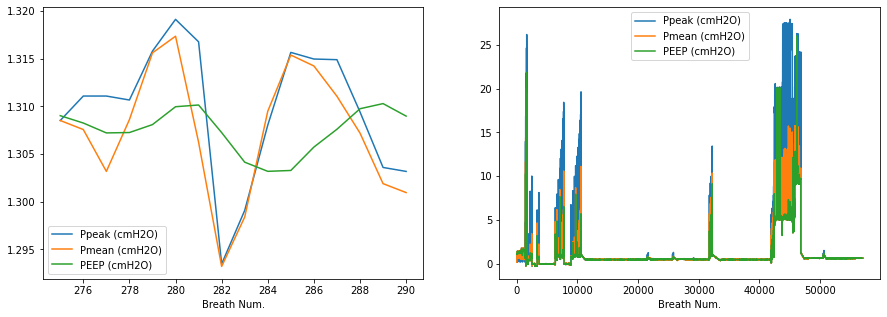

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

asl_breaths[(275 <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= 290)][["Breath Num.", "Ppeak (cmH2O)", "Pmean (cmH2O)", "PEEP (cmH2O)"]].plot("Breath Num.", ax=ax1)
asl_breaths[["Breath Num.", "Ppeak (cmH2O)", "Pmean (cmH2O)", "PEEP (cmH2O)"]].plot("Breath Num.", ax=ax2)

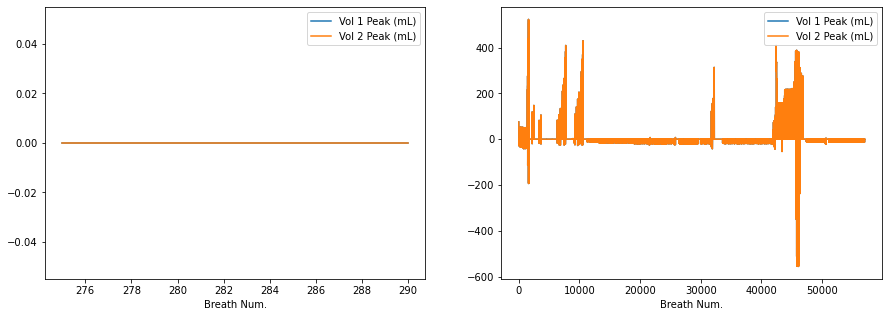

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

asl_breaths[(275 <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= 290)][["Breath Num.", "Vol 1 Peak (mL)", "Vol 2 Peak (mL)"]].plot("Breath Num.", ax=ax1)
asl_breaths[["Breath Num.", "Vol 1 Peak (mL)", "Vol 2 Peak (mL)"]].plot("Breath Num.", ax=ax2)

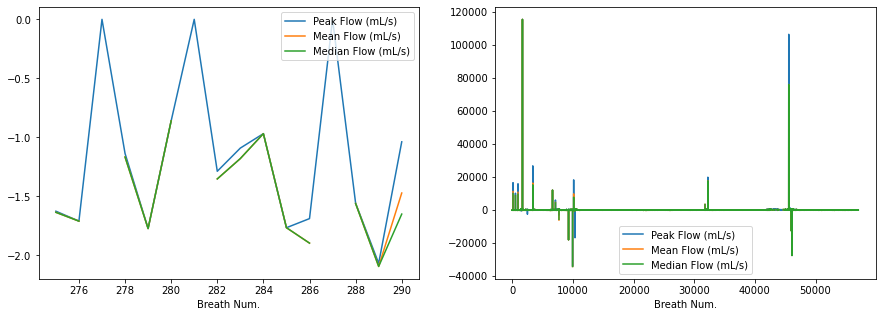

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

asl_breaths[(275 <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= 290)][["Breath Num.", "Peak Flow (mL/s)", "Mean Flow (mL/s)", "Median Flow (mL/s)"]].plot("Breath Num.", ax=ax1)
asl_breaths[["Breath Num.", "Peak Flow (mL/s)", "Mean Flow (mL/s)", "Median Flow (mL/s)"]].plot("Breath Num.", ax=ax2)

## Searching for a similar pattern between the ASL timeseries and the ASL breaths

### Using pressure

(-8.0, 35.0)

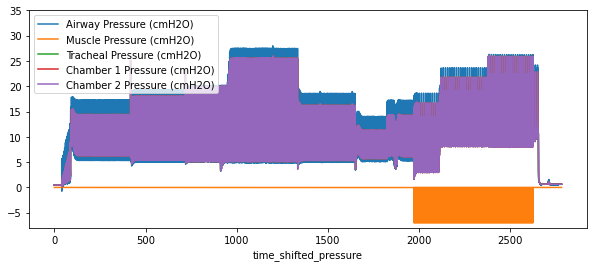

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
asl_timeseries[(0 < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < high + 3000)].plot("time_shifted_pressure", [
    "Airway Pressure (cmH2O)", "Muscle Pressure (cmH2O)", "Tracheal Pressure (cmH2O)", "Chamber 1 Pressure (cmH2O)", "Chamber 2 Pressure (cmH2O)"], ax=ax)
ax.set_ylim(-8, 35)

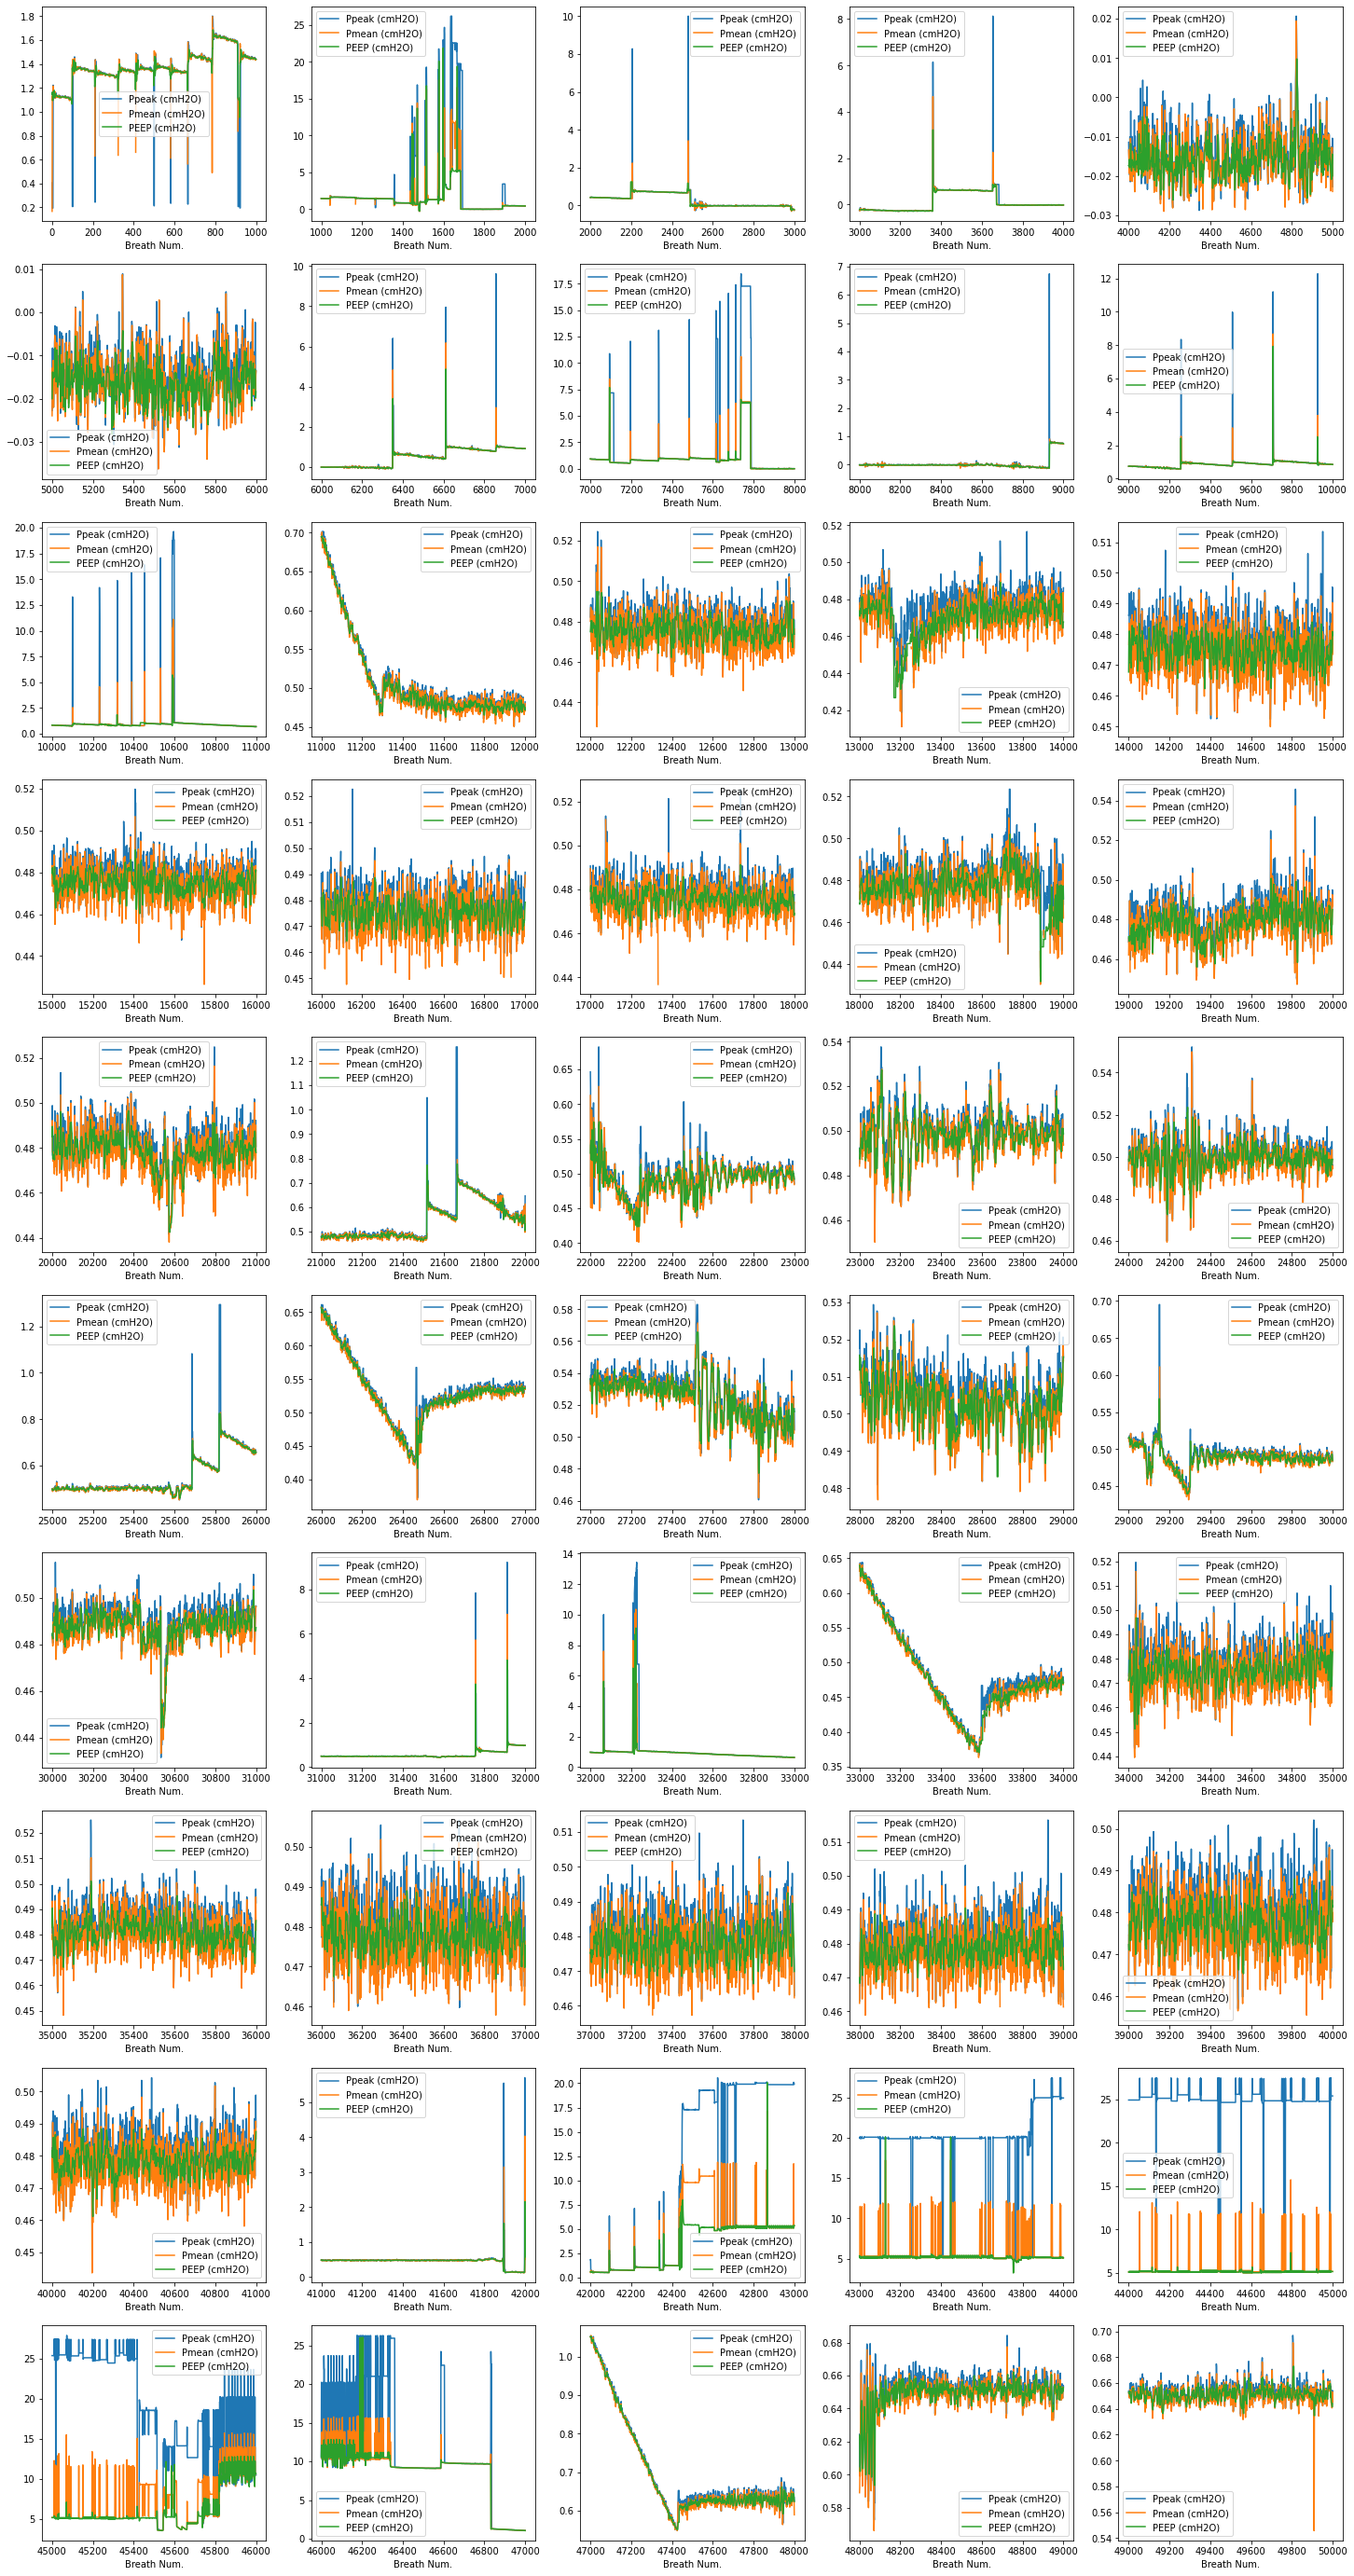

In [20]:
fig, axes = plt.subplots(10, 5, figsize=(25, 50))

for i, start in enumerate(range(0, 50000, 1000)):
    asl_breaths[(start <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= start + 1000)][["Breath Num.", "Ppeak (cmH2O)", "Pmean (cmH2O)", "PEEP (cmH2O)"]].plot("Breath Num.", ax=axes.ravel()[i])

### Using volume

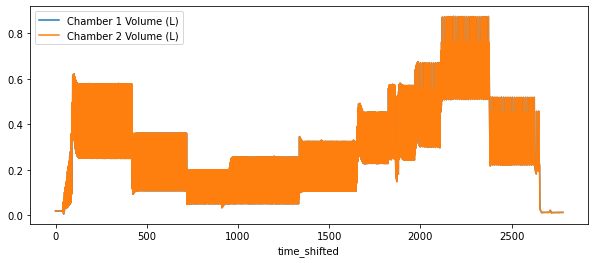

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
asl_timeseries[(0 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high + 3000)].plot("time_shifted", ["Chamber 1 Volume (L)", "Chamber 2 Volume (L)"], ax=ax)

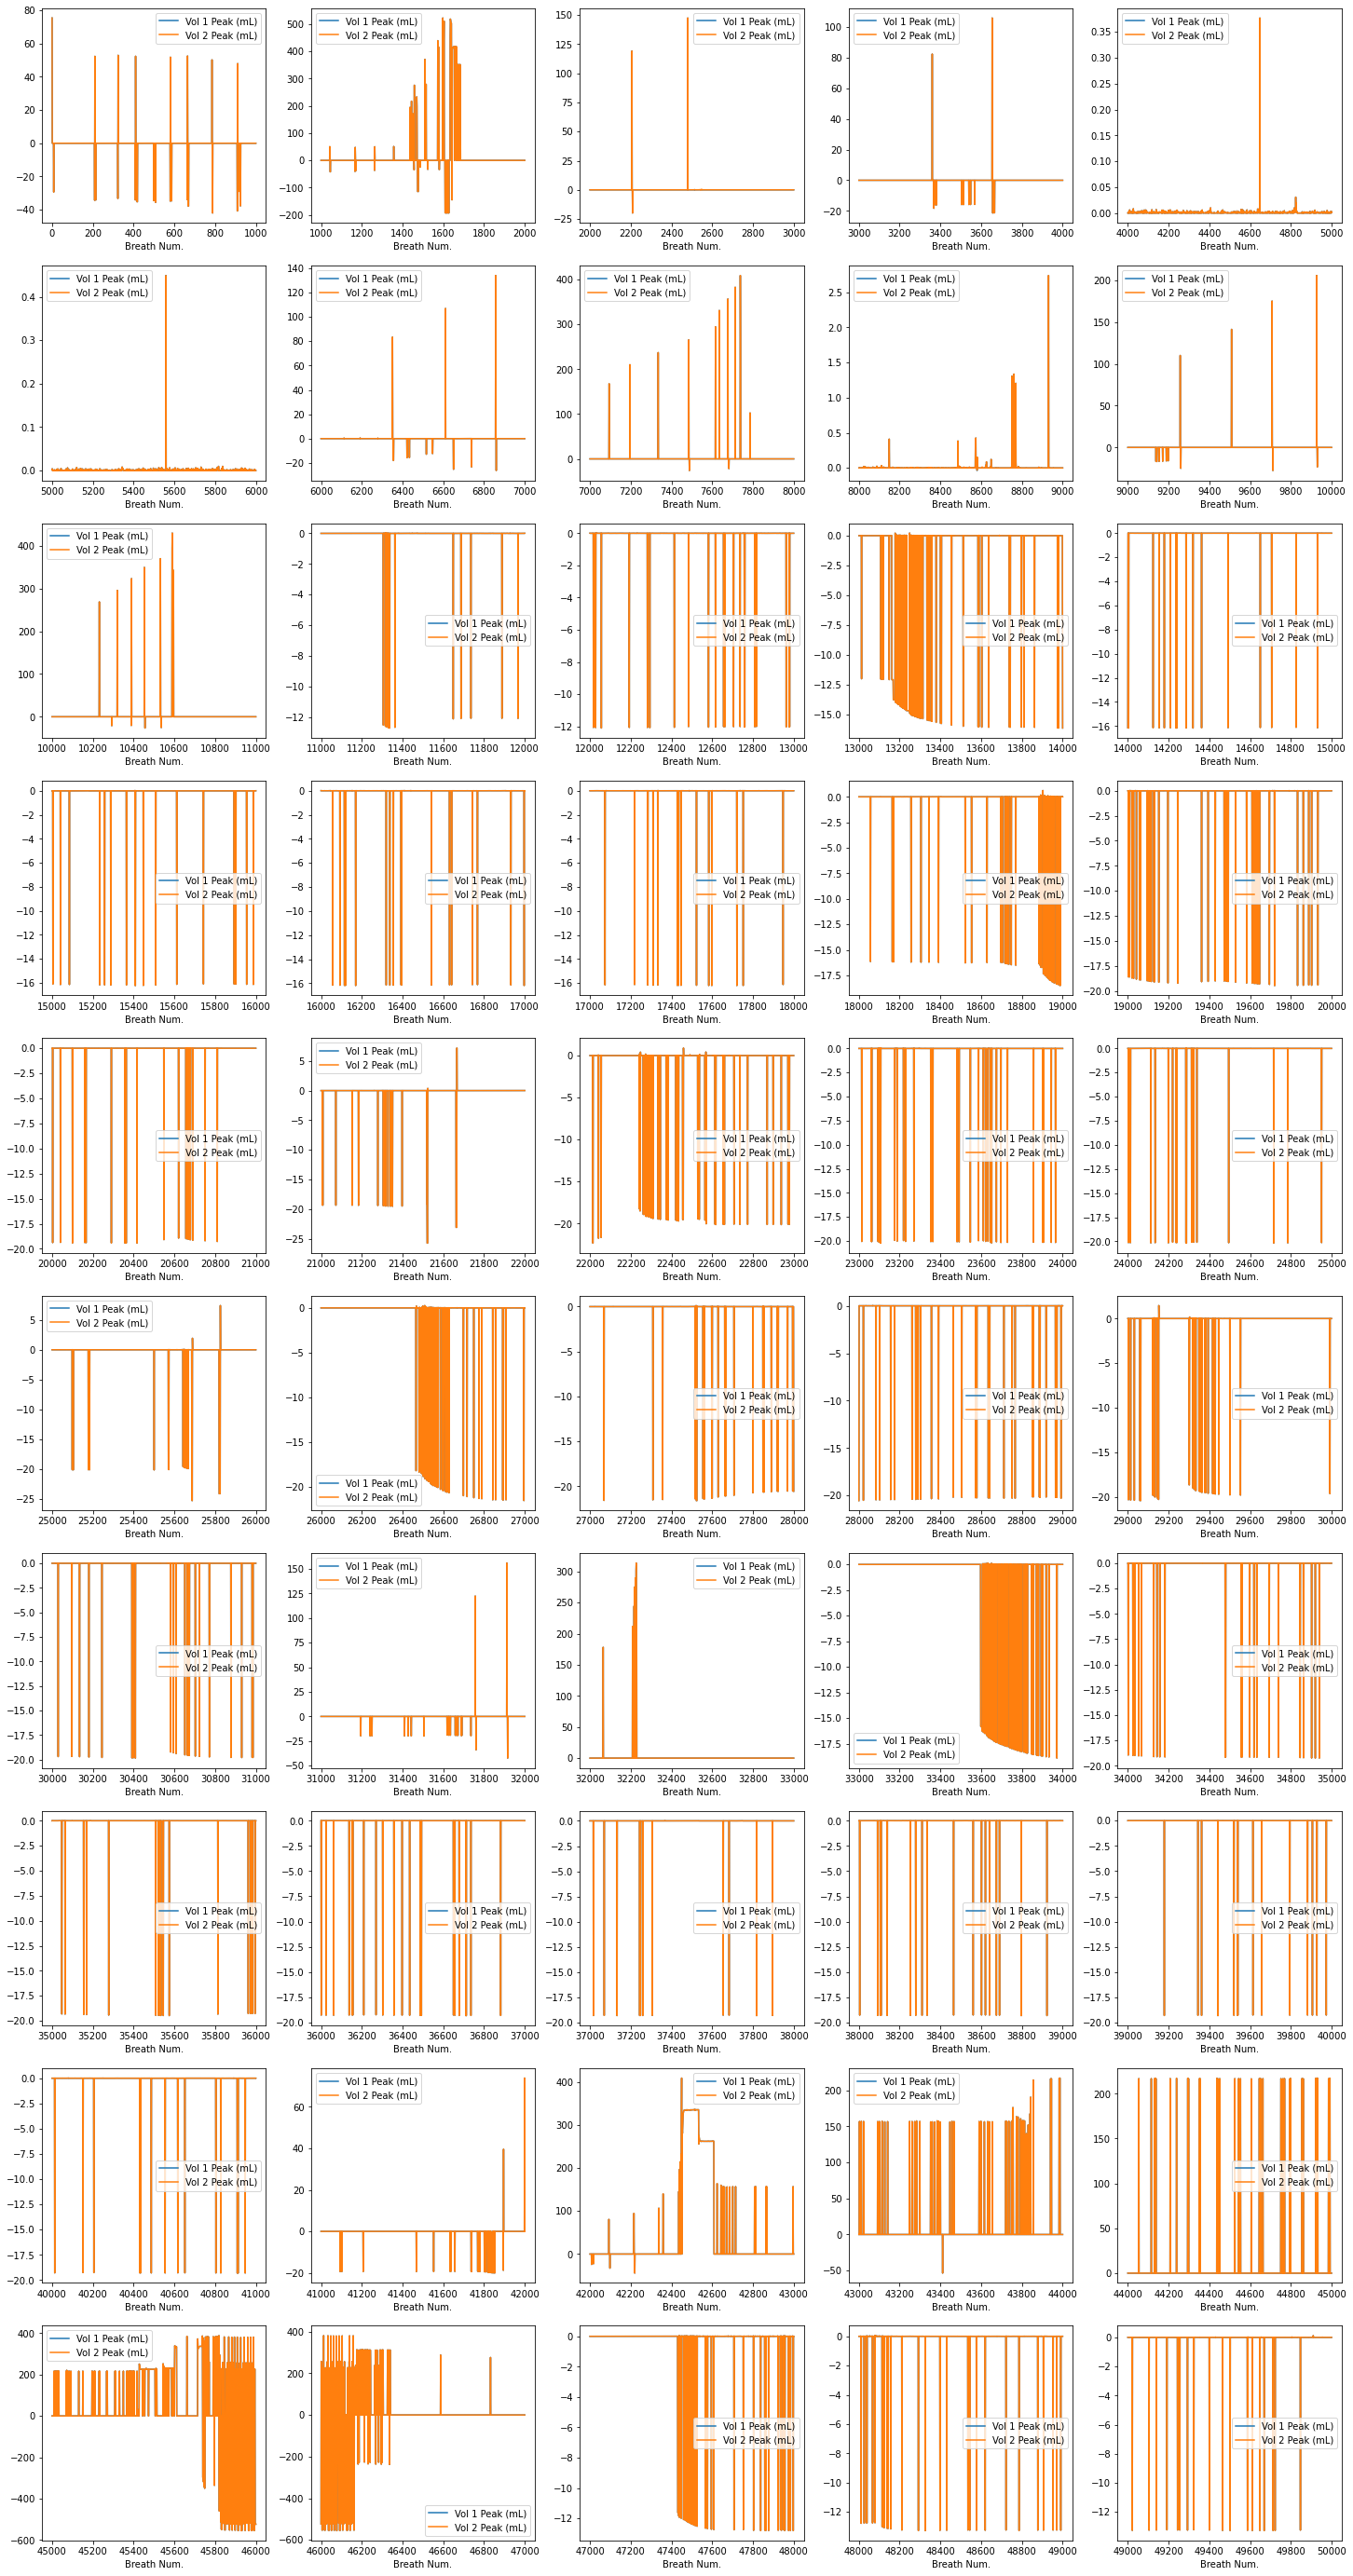

In [22]:
fig, axes = plt.subplots(10, 5, figsize=(25, 50))

for i, start in enumerate(range(0, 50000, 1000)):
    asl_breaths[(start <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= start + 1000)][["Breath Num.", "Vol 1 Peak (mL)", "Vol 2 Peak (mL)"]].plot("Breath Num.", ax=axes.ravel()[i])

### The most promising region: breath numbers 42400‒42600

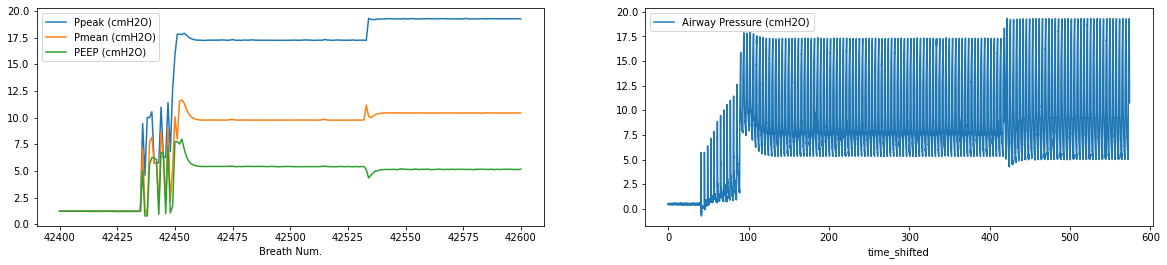

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
asl_breaths[(42400 <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= 42600)][["Breath Num.", "Ppeak (cmH2O)", "Pmean (cmH2O)", "PEEP (cmH2O)"]].plot("Breath Num.", ax=ax1)
asl_timeseries[(0 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high + 400)].plot("time_shifted", ["Airway Pressure (cmH2O)"], ax=ax2)

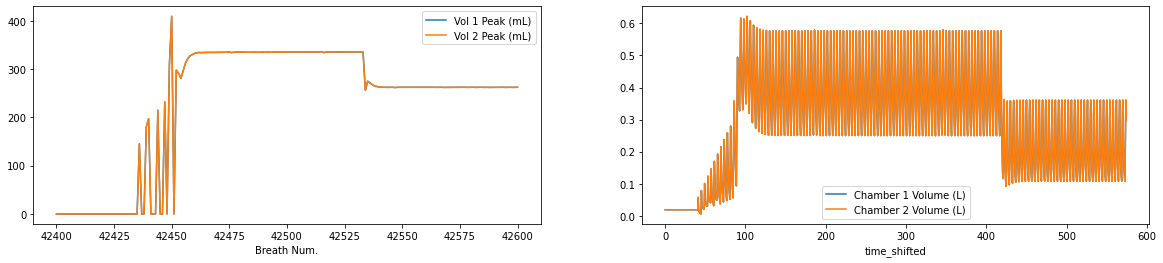

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
asl_breaths[(42400 <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= 42600)][["Breath Num.", "Vol 1 Peak (mL)", "Vol 2 Peak (mL)"]].plot("Breath Num.", ax=ax1)
asl_timeseries[(0 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high + 400)].plot("time_shifted", ["Chamber 1 Volume (L)", "Chamber 2 Volume (L)"], ax=ax2)

In [25]:
pd.options.display.max_rows = 150
asl_breaths_relevant = asl_breaths[(42475 <= asl_breaths["Breath Num."]) & (asl_breaths["Breath Num."] <= 42480)]
asl_breaths_relevant.T

,42475,42476,42477,42478,42479,42480
Breath Num.,42475.000000,42476.000000,42477.000000,42478.000000,42479.000000,42480.000000
Breath Type,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I Time (s),1.378906,1.376953,1.378906,1.378906,1.380859,1.380859
Insp (%),34.489498,34.457478,34.506355,34.489498,34.555229,34.538349
E Time (s),2.619141,2.619141,2.617188,2.619141,2.615234,2.617188
Pause Time (s),0.173828,0.171875,0.173828,0.171875,0.175781,0.173828
Pause (%),4.347826,4.301075,4.349951,4.298974,4.398827,4.347826
Insp Vt (mL),671.090698,668.021973,670.140991,670.043396,670.305420,670.514832
Exp Vt (mL),672.132202,671.079956,670.384399,670.058899,669.961792,670.319336
Ppeak (cmH2O),17.328909,17.271687,17.253792,17.267664,17.250324,17.283201


## Find the same region in our breath records

In [26]:
our_breaths_relevant = our_breaths[((110 < our_breaths["inhale timestamp (sec)"].astype(float)) |
                                    (110 < our_breaths["exhale timestamp (sec)"].astype(float)) |
                                    (110 < our_breaths["full timestamp (sec)"].astype(float)) |
                                    (110 < our_breaths["empty timestamp (sec)"].astype(float))) &
                                   ((our_breaths["inhale timestamp (sec)"].astype(float) < 174) |
                                    (our_breaths["exhale timestamp (sec)"].astype(float) < 174) |
                                    (our_breaths["full timestamp (sec)"].astype(float) < 174) |
                                    (our_breaths["empty timestamp (sec)"].astype(float) < 174))]
our_breaths_relevant.T

,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
inhale timestamp (sec),109.091,113.096,117.099,121.09,125.076,129.08,133.067,137.074,141.055,145.06,149.063,153.049,157.054,161.054,165.045,169.05,173.036
inhale flow (L/min),37.2819,38.8342,39.8167,39.8369,39.1021,41.0792,40.3212,39.1021,41.3361,41.0198,39.6542,39.7355,39.3073,40.0998,40.4416,39.8977,40.2609
inhale dV/dt (mL/sec),594.705,616.146,624.908,628.752,637.616,635.973,636.375,638.034,635.287,637.321,636.694,635.727,639.94,640.291,638.349,639.675,641.108
inhale dP/dt (cm H2O/sec),6.5252,6.4164,6.2193,6.45619,6.10276,6.5721,6.88331,5.94,7.17006,6.78525,6.57022,7.04252,6.03628,5.94833,6.8505,6.5481,6.27717
inhale compliance (ml/cm H2O),91.1397,96.0268,100.479,97.3874,104.48,96.7686,92.4519,107.413,88.6027,93.9274,96.906,90.2699,106.016,107.642,93.1829,97.6886,102.133
min pressure (cm H2O),5.2108,4.8202,4.5824,4.4588,4.3926,4.3485,4.3391,4.343,4.3493,4.3454,4.3477,4.3422,4.358,4.3564,4.3414,4.3312,4.3461
full timestamp (sec),110.031,114.019,118.02,122.01,125.997,130.003,133.992,137.994,141.999,145.981,149.985,153.989,157.974,161.974,165.966,169.97,173.976
full pressure (cm H2O),12.9449,15.2215,14.6837,15.2971,14.1797,12.9008,16.139,15.7011,14.7734,16.2925,13.2229,12.5456,16.2634,15.9901,16.4358,13.1284,14.5671
full volume (mL),733.241,756.517,765.302,770.196,774.546,773.891,781.637,779.057,777.796,779.878,775.787,775.809,778.844,780.986,777.638,773.693,778.18
expiratory tidal volume (mL),611.1651999999999,631.6527,635.4363999999999,638.313,641.3207,639.0717000000001,644.5725,639.8202,641.3808,642.4561,637.7646,637.86,641.6202,644.4873,642.4244,637.1394,641.6347


## Best guess associations between derived quantities

```
     | our fieldname              our value    ASL fieldname  ASL value
-----+-----------------------------------------------------------------
PIP  | max pressure               18.3 cm H2O  Ppeak (cmH2O)  17.3
PEEP | empty pressure              4.4 cm H2O  PEEP (cmH2O)    5.4
TVi  | inspiratory tidal volume    640 mL      Insp Vt (mL)    670
TVe  | expiratory tidal volume     640 mL      Exp Vt (mL)     670
I:E  | inhale time / exhale time  nan/nan      I/E            0.52
```

## Time since first breath in POVM

From Andy:

> Hi @Jim Pivarski Here are three time points i n he video, with mins and seconds elapsed since the first breath (which should be easy to detect on the POVM). I have pulled out derived quantities by reading off the screen of the ventilator in the video. The first point is for the ventulator under volume control. This is very regular.. each breath is the same. The second two time points are from synchronized pressure control. This one has variability in tidal volume and PIP from one breath to the next, so it may be harder to compare.
> 
> 1:50 s in video is first breath of ventilator.. should be first breath in recording
> 0m 0 s post first breath
> 
> 23 m 04 s in Video
> 21 m 14 s post first breath: under volume control; PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm
> 
> 37 m 45 s in Video
> 35 m 55 s post first breath: under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 16 cmH20 [jumps back and forth between 23ish and 16ish]; TVexp 527 [jummps back and forth between 530ish and 700 ish3] ml; RR not reported.
> 
> 40m 32s in Video
> 38m 42s post first breath:  under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 21 cmH20; TVexp 507ml; RR not reported (edited) 
> 
> 9:30
> could you see what the values are that the POVM reports for these time points/

It looks like the "first breath" is at 40 seconds in the common time used by this analysis. There's 1‒2 seconds of uncertainty about what that means, and we could be off by one breath or so.

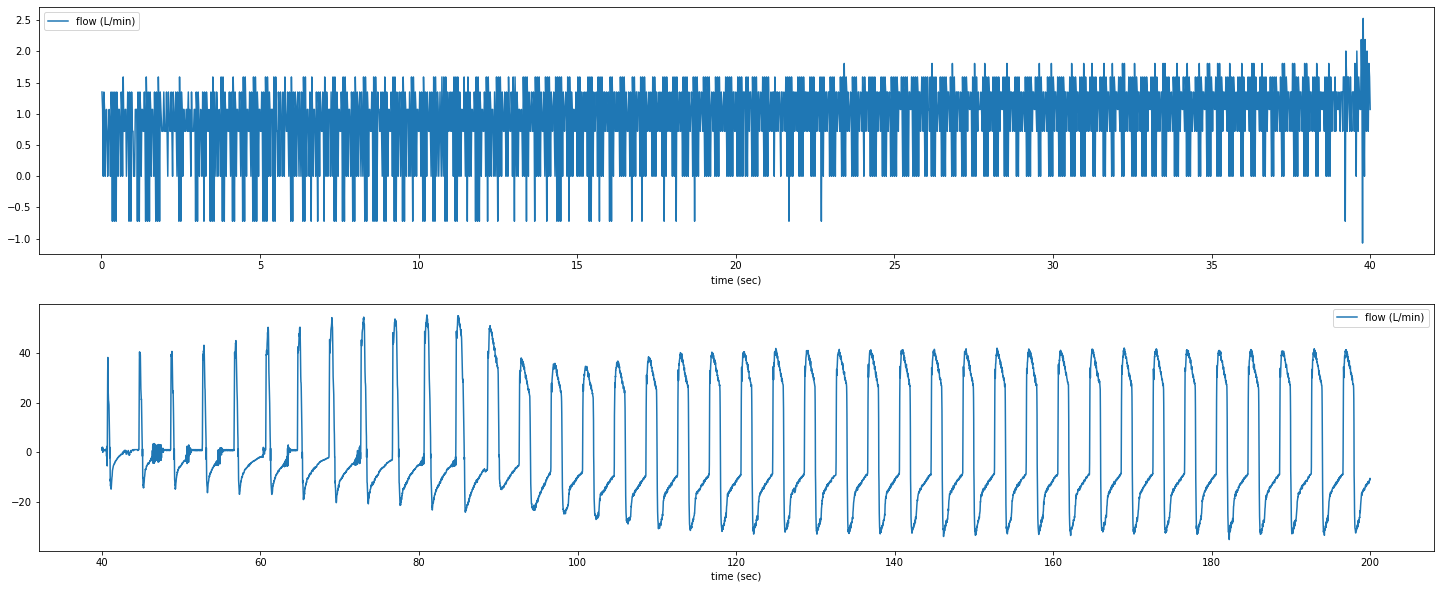

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
our_timeseries[(0 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < 40)].plot("time (sec)", "flow (L/min)", ax=ax1)
our_timeseries[(40 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < 200)].plot("time (sec)", "flow (L/min)", ax=ax2)

In [30]:
our_breaths.iloc[:10]

,inhale timestamp (sec),inhale flow (L/min),inhale dV/dt (mL/sec),inhale dP/dt (cm H2O/sec),inhale compliance (ml/cm H2O),min pressure (cm H2O),full timestamp (sec),full pressure (cm H2O),full volume (mL),expiratory tidal volume (mL),...,exhale dP/dT (cm H2O/sec),exhale compliance (ml/cm H2O),max pressure (cm H2O),empty timestamp (sec),empty pressure (cm H2O),empty volume (mL),exhale time (sec),average flow (L/min),average pressure (cm H2O),time since last (sec)
0,40.764000,38.2733,163.159314,2.580221,63.234627,nan,41.044000,0.5228,473.2305,nan,...,-0.878237,147.122343,7.8072,43.064499999999995,-0.4899,354.1009,nan,nan,nan,nan
1,44.825000,38.1687,316.186431,4.670678,67.696052,-1.112,45.185000,-1.3128,508.5437,154.44279999999998,...,-0.342405,392.116560,8.4128,47.13602222222223,-0.1962,360.1115,nan,0.9061990196078437,0.1967941176470588,nan
2,48.847044,40.7215,337.888723,3.662988,92.244006,-0.534,49.187067,-0.7789,523.3885,163.27700000000004,...,-1.212890,121.931272,9.2216,51.108999999999995,0.0976,342.6396,nan,0.6203217171717174,0.5621944444444444,nan
3,52.869078,43.1976,389.210240,1.829615,212.727945,-0.2836,53.229844,-0.4096,544.3130,201.67340000000002,...,-1.651000,102.582467,10.3067,55.11430000000001,0.4189,336.4437,nan,0.8131910447761196,0.9300835820895522,nan
4,56.876000,43.4641,432.391585,5.874595,73.603647,-0.0544,57.256000,0.1094,562.9837,226.54000000000002,...,-1.587964,119.286326,11.2895,60.31600000000002,-0.0371,307.7576,nan,-0.1850434615384612,0.988816923076923,nan
5,60.916433,46.8591,543.319211,7.015952,77.440554,-0.0576,61.336900,1.2276,592.0748,284.31719999999996,...,-1.914783,107.668507,13.0307,63.696999999999996,0.6047,304.6951,nan,0.7826976190476194,1.914427380952381,nan
6,64.917000,46.8771,561.391387,4.802724,116.890199,0.0558,65.337000,2.3766,619.0380,314.3429,...,-2.076558,109.386032,13.6087,68.40100000000001,0.0685,283.1447,nan,-0.22314025423728778,1.660934745762712,nan
7,68.961000,51.3474,658.059136,5.487755,119.914093,0.033,69.421000,1.9498,634.5983,351.4536,...,-2.609470,94.471943,14.4498,72.38114444444443,0.133,269.2705,nan,0.07976381909547763,2.3134371859296485,nan
8,72.981833,53.1175,702.020345,4.497520,156.090531,0.1141,73.442111,3.0334,662.6890,393.41849999999994,...,-2.749520,94.312608,14.9065,76.40491111111109,0.2165,254.9895,nan,0.13191400000000045,2.665732,nan
9,76.985967,53.8166,731.663634,9.339170,78.343541,0.1645,77.486056,3.7043,676.7393,421.74979999999994,...,-2.706283,104.932276,15.2562,80.41003333333333,0.3425,240.6516,nan,0.01874328358208988,2.9754398009950247,nan


In [48]:
our_breaths["PIP"] = our_breaths["max pressure (cm H2O)"].astype(float)
our_breaths["PEEP"] = our_breaths["empty pressure (cm H2O)"].astype(float)
our_breaths["TVi"] = our_breaths["inspiratory tidal volume (mL)"].astype(float)
our_breaths["TVe"] = our_breaths["expiratory tidal volume (mL)"].astype(float)
our_breaths["I:E"] = our_breaths["inhale time (sec)"].astype(float) / our_breaths["exhale time (sec)"].astype(float)
our_breaths["RR"] = 60 / our_breaths["time since last (sec)"].astype(float)

### First comparison

> 23 m 04 s in Video 21 m 14 s post first breath: under volume control; PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm

(0.0, 40.0)

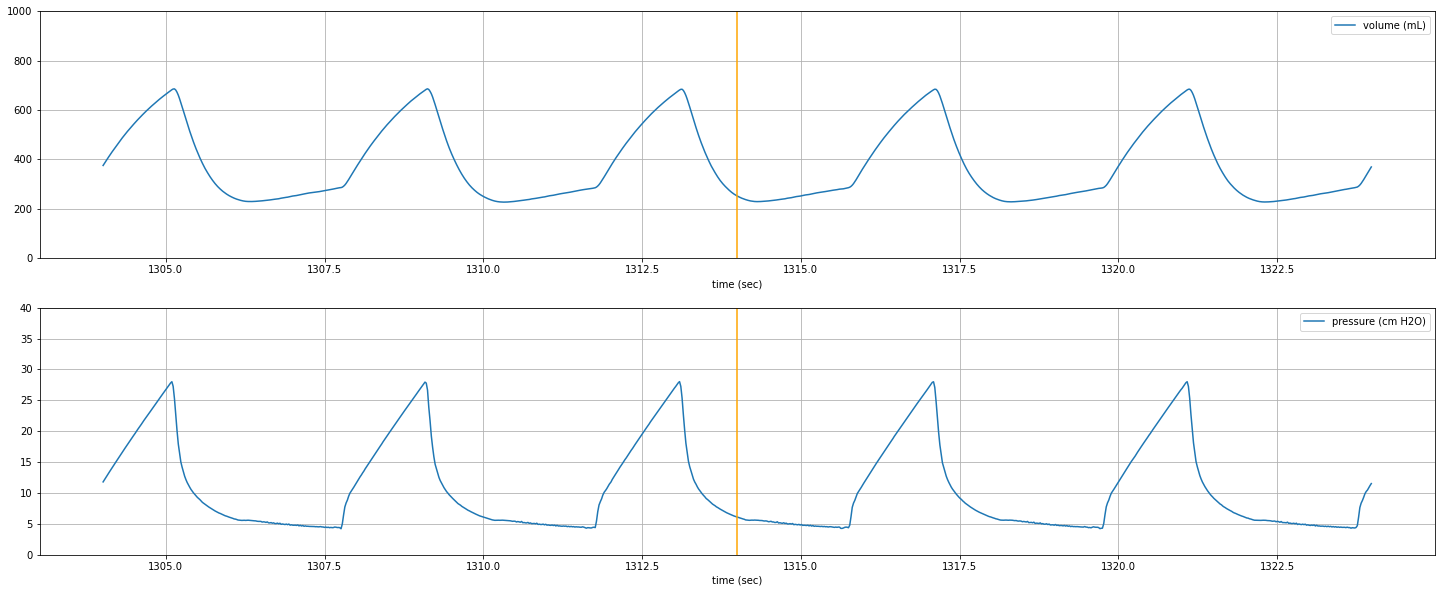

In [69]:
central_value = 40 + 21*60 + 14

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "volume (mL)", ax=ax1)
our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "pressure (cm H2O)", ax=ax2)
ax1.axvline(central_value, c="orange")
ax1.grid()
ax1.set_ylim(0, 1000)
ax2.axvline(central_value, c="orange")
ax2.grid()
ax2.set_ylim(0, 40)

In [70]:
our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["exhale timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["full timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["empty timestamp (sec)"].astype(float))) &
                                   ((our_breaths["inhale timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["exhale timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["full timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["empty timestamp (sec)"].astype(float) < central_value + 10))]
our_breaths_relevant[["PIP", "PEEP", "TVi", "TVe", "I:E", "RR"]]

,PIP,PEEP,TVi,TVe,I:E,RR
316,28.0216,4.4367,408.6023,406.0075,NaN,NaN
317,27.9562,4.5060,409.4489,410.2471,NaN,NaN
318,28.0412,4.5493,403.2564,402.9989,NaN,NaN
319,28.0105,4.5729,406.8069,404.4016,NaN,NaN
320,28.0239,4.4430,402.9452,405.9172,NaN,NaN


### Second comparison

> 37 m 45 s in Video
> 35 m 55 s post first breath: under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 16 cmH20 [jumps back and forth between 23ish and 16ish]; TVexp 527 [jummps back and forth between 530ish and 700 ish3] ml; RR not reported.

(0.0, 40.0)

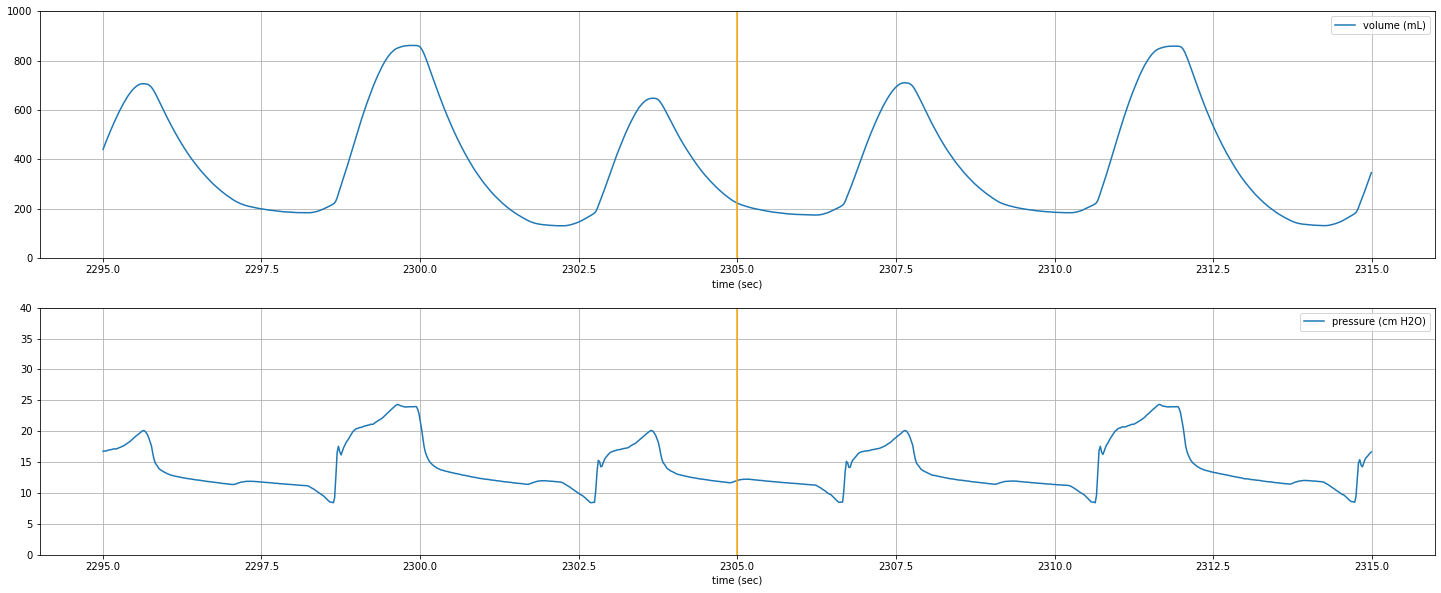

In [71]:
central_value = 40 + 37*60 + 45

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "volume (mL)", ax=ax1)
our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "pressure (cm H2O)", ax=ax2)
ax1.axvline(central_value, c="orange")
ax1.grid()
ax1.set_ylim(0, 1000)
ax2.axvline(central_value, c="orange")
ax2.grid()
ax2.set_ylim(0, 40)

In [72]:
our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["exhale timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["full timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["empty timestamp (sec)"].astype(float))) &
                                   ((our_breaths["inhale timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["exhale timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["full timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["empty timestamp (sec)"].astype(float) < central_value + 10))]
our_breaths_relevant[["PIP", "PEEP", "TVi", "TVe", "I:E", "RR"]]

,PIP,PEEP,TVi,TVe,I:E,RR
562,20.1127,10.1422,506.7755,518.7266,NaN,NaN
563,24.3423,10.0169,712.9351,667.3722,NaN,NaN
564,20.1135,10.2146,462.5257,499.4501,NaN,NaN
565,20.1229,10.1303,510.0977,518.7593,NaN,NaN
566,24.3353,10.0973,711.7154,666.7975,NaN,NaN


### Third comparison

> 40m 32s in Video
> 38m 42s post first breath:  under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 21 cmH20; TVexp 507ml; RR not reported

(0.0, 40.0)

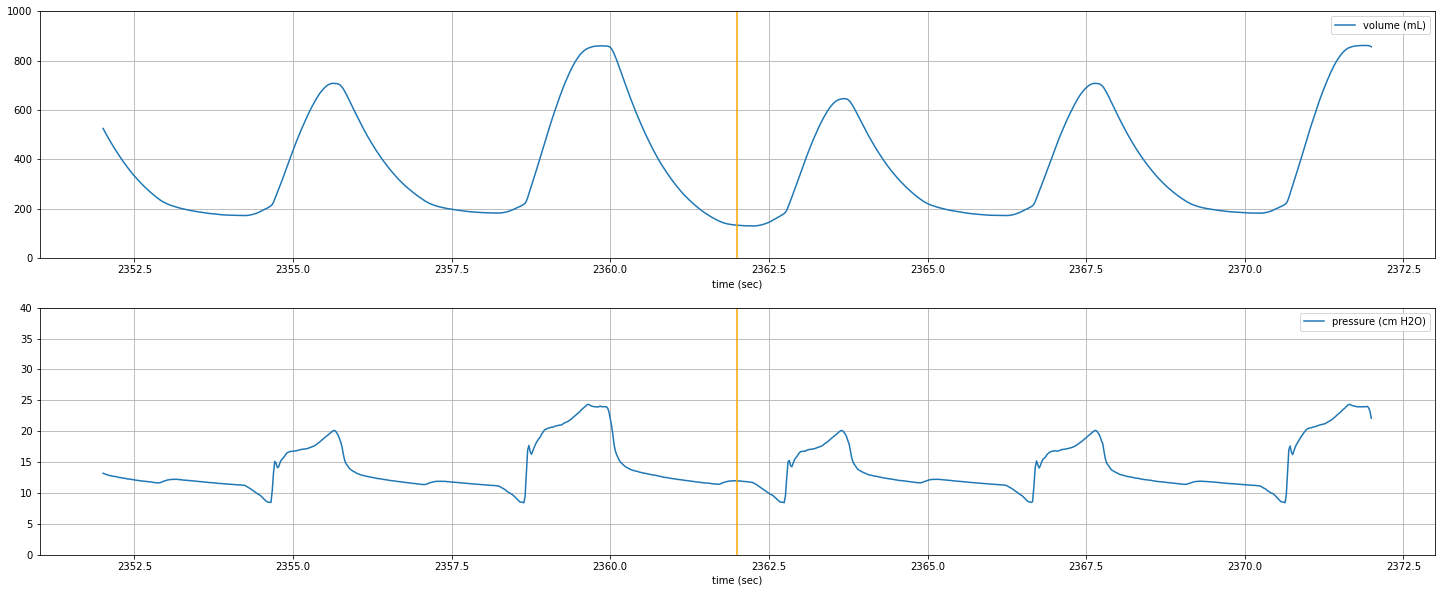

In [73]:
central_value = 40 + 38*60 + 42

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "volume (mL)", ax=ax1)
our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "pressure (cm H2O)", ax=ax2)
ax1.axvline(central_value, c="orange")
ax1.grid()
ax1.set_ylim(0, 1000)
ax2.axvline(central_value, c="orange")
ax2.grid()
ax2.set_ylim(0, 40)

In [74]:
our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["exhale timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["full timestamp (sec)"].astype(float)) |
                                    (central_value - 10 < our_breaths["empty timestamp (sec)"].astype(float))) &
                                   ((our_breaths["inhale timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["exhale timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["full timestamp (sec)"].astype(float) < central_value + 10) |
                                    (our_breaths["empty timestamp (sec)"].astype(float) < central_value + 10))]
our_breaths_relevant[["PIP", "PEEP", "TVi", "TVe", "I:E", "RR"]]

,PIP,PEEP,TVi,TVe,I:E,RR
576,20.1379,10.0894,464.7099,503.1232,NaN,NaN
577,20.1229,10.0933,512.9550,521.4729,NaN,NaN
578,24.3447,9.9508,711.4192,667.1831,NaN,NaN
579,20.1300,10.1122,463.3310,499.2864,NaN,NaN
580,20.1355,10.1650,511.1801,518.8963,NaN,NaN
581,24.3549,10.0540,716.7386,669.6739,NaN,NaN
